# Project Simulation et Monte-Carlo

**CHEDRI Axel, CHRIMNI Walid, DUFLOT Quentin**

## Introduction

Le modèle de Potts est une généralisation du modèle d’Ising permettant un nombre de modalités supérieur à deux : On considère un vecteur aléatoire $x=(x_1,...,x_n)$ à valeurs dans $ \{1, . . . , K\}^n $ K > 2, dont la probabilité est:


$$ π(x) = \frac{1}{\text{Z}(β)} \text{exp}\left\{β \sum_{i∼j}^{} \mathbb{1}[x_i = x_j])\right\} $$

où
* $β$ > 0 
*  Z($β$) = $ \sum_{x_1,...,x_n \in \{1,...,K\}^n}^{} \text{exp}\left\{β \sum_{i∼j}^{} \mathbb{1}[x_i = x_j])\right\} $ est une constante de normalisation
* i ∼ j est une relation de voisinage (par exemple j est un des quatre pixels
adjacents au pixel i, dans le cas où les xi représentent les pixels d’une image
rectangulaire).

Ce projet est construit sur la programmation orientée objet. Toutes nos fonctions sont basées sur des classes. Les raisons principales à cela sont les suivantes :

* Utilisation et réutilisation plus facile 
* Un code plus élégant et clair
* Maintenance et évolutivité plus efficace

Toutes nos classes se trouvent dans le fichier MonteCarloClasses.py que l'on importe dans la cellule suivante. Les packages de bases dont nous avons besoin (numpy, matplotlib etc...) sont également présenté dans le module MonteCarloClasses

En outre, pour plus de clarté les codes utilisés pour construire nos classes ne seront pas montrés dans ce notebook. Cependant, vous trouverez ci-dessous un "mode d'emploi" pour savoir comment utilisé chaque classe.

### Mode d'emploi

Pour créer un objet de la classe *GibbsSampler*, il suffit de lancer la commande  ``` GibbsSampler(n, beta, K, relation) ``` où
* n correspond à la taille du vecteur $x$
* beta correspond au paramètre $β$
* K correspond au paramètre K
* relation est une fonction Python telle que relation(i,j) = 1 si i~j

Des valeurs sont affectés par défaut à ces paramètres, il est donc possible de créer une instance de classe seulement via ```GibbsSampler()```

Les méthodes ```plot(nb_sample, composante, start)``` et ``` plot_acf(nb_sample, composante, start)``` permettent de tracer respectivement le graphe au cours du temps et le graphe de correlation où
* nb_sample correspond au nombre d'itération de l'algorithme pour la simulation de l'echantillon
* compostante correspond à la compostante du vecteur que l'on veut simuler
* start correspond au temps à partir duquel on affiche le graphe (pour les problèmes où la convergence est plus lente)

**Pour toutes les méthodes, des valeurs par défauts sont affectées aux paramètres afin de permettre de lancer rapidement un programme**

In [1]:
from utils import *

## Question 1 

> Pour β et K fixé, proposer un Gibbs sampler pour simuler selon la loi du modèle. Déterminer la performance de l’algorithme en fonction de ces paramètres.

Pour la création technique du modèle et du code associé, voir la création de la classe "GibbsSampler" du fichier "MonteCarloClasses.py"

Dans un premier temps, nous créons notre instance de classe :

In [91]:
gibbs = GibbsSampler(n=30, beta=1, K=10, relation=lambda x,y : x==y+1 or x==y-1 or x==y-2 or x==y+2 or x==y-3 or x==y+3)

On génère la réalisation de la variable aléatoire $x$ qui suit la loi mentionnée en introduction :

In [75]:
gibbs.simulate(nb_sample=500)

array([0., 6., 8., 0., 0., 1., 0., 3., 8., 2., 5., 8., 7., 5., 4., 4., 3.,
       4., 2., 8., 3., 1., 0., 0., 3., 5., 7., 5., 2., 4.])

In [53]:
gibbs.simulate(nb_sample=500).shape

(30,)

C'est un vecteur de taille 30 (=n), l'entrée i de l'array correspond à la réalisation de $x_i$

Visualisons la trace de $x_1$ :

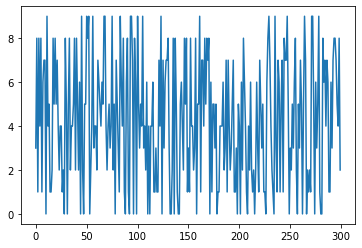

In [54]:
gibbs.plot(nb_sample=300)

La chaine "mélange" bien, la trace de $x_1$ semble bien être random. Confirmons cela par un graphe d'autocorellation :

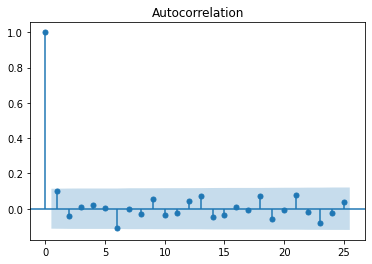

In [94]:
gibbs.acf_plot(nb_sample=300, composante=0, start=0)

Le graphe d'autocorellation va dans le sens de notre intuition précédente : $x_{1,0}$ n'est pas corrélé avec les $x_{1,k}$ pour $k>0$

## Question 2

In [2]:
gibbs2 = ImageCompression()

In [3]:
X, mu, sigma = gibbs2.gibbs_sampling()

100%|██████████| 10/10 [01:34<00:00,  9.44s/it]


## Question 3

In [2]:
img1 = ImageCompression.convert('ENSAE_image.jpg')

cmp1 = ImageCompression(y=img1)

In [3]:
cmp_img1 = cmp1.compress()

100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


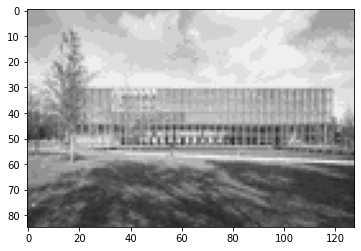

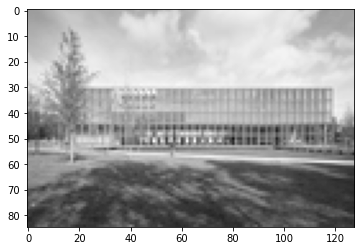

In [19]:
plt.figure()
show(cmp_img1)
plt.figure()
show(img1)